<Font size = 5> <strong>October Jode Jam

Prepared by Jeel Faldu, Jimmy Koester, and Raphael Lu

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#HuggingFace tools
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from google.colab import output

import urllib.request
disable_colab_widgets = output.disable_custom_widget_manager()

## Introduction

This project explores sentiment analysis using `distilbert-base-uncased-finetuned-sst-2-english` and `twitter-roberta-base-sentiment` from the Hugging Face Transformers library. The goal is to automatically classify text as positive, negative, or neutral using pretrained transformer models.

We analyzed sentiment in social media posts, compared multiple models, and visualized their performance and confidence levels. We also applied the models to a creative dataset, showcasing how NLP can reveal insights from real-world text such as tweets, song lyrics, or news articles.

## Device Loading

In [104]:
disable_colab_widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device Loaded: {device}")

Device Loaded: cuda


In [61]:
# model_1 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# model_2 = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

We intialized the DistilBERT tokenizer which prepares raw text for the model by converting it into tokens consistent with how the pretrained model was trained.

In [62]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Next, we set random seeds to ensure reproducibility, meaning that everytime the code runs, it produces the same results. This helps maintain consistency across experiments and makes debugging or comparision between models more reliable.

## Data Preprocessing

In data exploration, no duplicate entries were found. In the orignal data set, Tweets were encoded as

<pre>
    'nocode', 'happy', 'not-relevant', 'angry', 'disgust|angry'

    'disgust', 'happy|surprise', 'sad', 'surprise', 'happy|sad'

    'sad|disgust', 'sad|angry', 'sad|disgust|angry'
</pre>

### Summary of Data Preprocessing:
  - Fields were renamed `id`, `text`, and `label`
  - `id` field was ultimately dropped
  - Target labels were re-coded into arrays using OHE:
    - e.g. with sentiments

      `['angry' 'disgust' 'happy' 'nocode' 'not-relevant' 'sad' 'surprise']`, a tensor of `[1 0 0 0 0 1 0]` indicates an `angry|sad` tweet
  - Data were split using a 80:20 (train:test) ratio and stored in `X_train, X_test, y_train, y_test`


In [63]:
# Load datasets
data_url = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/datasets/dataset.csv'
df = pd.read_csv(data_url, header=None, names=['id', 'text', 'label'], sep=',')

data_train = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/datasets/training.csv'
df_train = pd.read_csv(data_train, header=None, names=['text', 'label'], sep=',')
data_test = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/datasets/test.csv'
df_test = pd.read_csv(data_test, header=None, names=['text', 'label'], sep=',')
data_val = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/datasets/validation.csv'
df_val = pd.read_csv(data_val, header=None, names=['text', 'label'], sep=',')



# Display first few rows of the dataset
display(df.head())
print()
display(df_train.head())
print()
display(df_test.head())
print()
display(df_val.head())

,id,text,label
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


,text,label
0,text,label
1,i didnt feel humiliated,0
2,i can go from feeling so hopeless to so damned...,0
3,im grabbing a minute to post i feel greedy wrong,3
4,i am ever feeling nostalgic about the fireplac...,2


,text,label
0,text,label
1,im feeling rather rotten so im not very ambiti...,0
2,im updating my blog because i feel shitty,0
3,i never make her separate from me because i do...,0
4,i left with my bouquet of red and yellow tulip...,1


,text,label
0,text,label
1,im feeling quite sad and sorry for myself but ...,0
2,i feel like i am still looking at a blank canv...,0
3,i feel like a faithful servant,2
4,i am just feeling cranky and blue,3


In [64]:
# Display the summary of the dataset
df.info()
print()
df_train.info()
print()
df_test.info()
print()
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3085 non-null   int64 
 1   text    3085 non-null   object
 2   label   3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16001 non-null  object
 1   label   16001 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2001 non-null   object
 1   label   2001 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
D

In [65]:
# Display the shape of all the DataFrame
n_rows, n_cols = df.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 3085 rows and 3 columns


In this step, we loaded the main dataset along with separate training, testing, and validation splits directly from GitHub. Loading them separately ensures proper evaluation and prevents data leakage between phases.

<font size = 5> <b> Let's check to see if there are any dupes in our datas

In [66]:
# Check for duplicates in the datasets
alt_df_train = df_train.duplicated().sum()
alt_df_val = df_val.duplicated().sum()
alt_df_test = df_test.duplicated().sum()

print(alt_df_train)
print(alt_df_val)
print(alt_df_test)

# Identify and remove duplicates in training set
dupe_df_train = df_train[df_train.duplicated()]
print(dupe_df_train)
df_train_no_dupes = df_train.drop_duplicates()
print(df_train_no_dupes.shape)

1
0
0
                                                    text label
13847  i feel more adventurous willing to take risks ...     1
(16000, 2)


In this step, we checked for and removed duplicate entries in the training dataset to ensure data quality and prevent bias during training. Duplicate rows can cause models to overfit or skew performance metrics.

In [67]:
# Map numeric labels to string labels
label_mapping = {
    '0': 'sad',
    '1': 'happy',
    '2': 'happy',
    '3': 'angry',
    '4': 'fear',
    'sad': 'sad',
    'happy': 'happy',
    'angry': 'angry',
    'fear': 'fear'
}

df_train_no_dupes['label'] = df_train_no_dupes['label'].map(label_mapping)

/tmp/ipython-input-616060926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_no_dupes['label'] = df_train_no_dupes['label'].map(label_mapping)


We also standardized the label values using a mapping dictionary so that both numeric and text-based labels were aligned to a consistent format (e.g., mapping 0 and 1 to “sad” and “happy”). This helped maintain uniformity across datasets and simplified the classification process.

### Train-Test-Split

In [68]:
# Combine train and validation
alt_df = pd.concat([df_train, df_val], ignore_index=True)

# Apply label mapping
#alt_df = alt_df[alt_df['label'] != 'fear']
#alt_df['label'] = alt_df['label'].replace({'love': 'happy', 'joy': 'happy'})

alt_df['label'] = alt_df['label'].map(label_mapping)
alt_df = alt_df.dropna()

After completing the initial data preprocessing - removing duplicates and standardizing labels - we combined the training and validation datasets to create a larger dataset for model training which can help improve learning by providing more examples.

#### Data Splits for RoBERTa Model

In [69]:
# Train two different test splits for the Roberta Model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare training and testing features
X_train = train_df.drop('label', axis = 1)
X_test = test_df.drop('label', axis = 1)

# Combine all labels for fitting
all_labels = pd.concat([train_df['label'], alt_df['label']])
mlb = MultiLabelBinarizer()
mlb.fit(all_labels.str.split('|'))

# Transform labels
y_train = mlb.transform(train_df['label'].str.split('|'))
y_test = mlb.transform(test_df['label'].str.split('|'))

In [70]:
# Display shapes of the datasets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Check label mapping
print("\nLabel classes:")
print(mlb.classes_)

# Check a sample label
print(mlb.classes_)
print(y_train[92])

(2468, 2) (2468, 8)
(617, 2) (617, 8)

Label classes:
['angry' 'disgust' 'fear' 'happy' 'nocode' 'not-relevant' 'sad' 'surprise']
['angry' 'disgust' 'fear' 'happy' 'nocode' 'not-relevant' 'sad' 'surprise']
[0 0 0 1 0 0 0 0]


At this stage, we prepared the data specifically for the RoBERTa model. We split the dataset into training and test sets and separated the features (text) from the labels. To handle multi-label emotions, we combined all labels from the training and combined dataset and applied a multi-label binarizer, which converts each label into a one-hot encoded vector. This step ensures the model can handle tweets that express multiple emotions at once. The resulting shapes and label classes confirm that the data is correctly formatted and ready for model training.

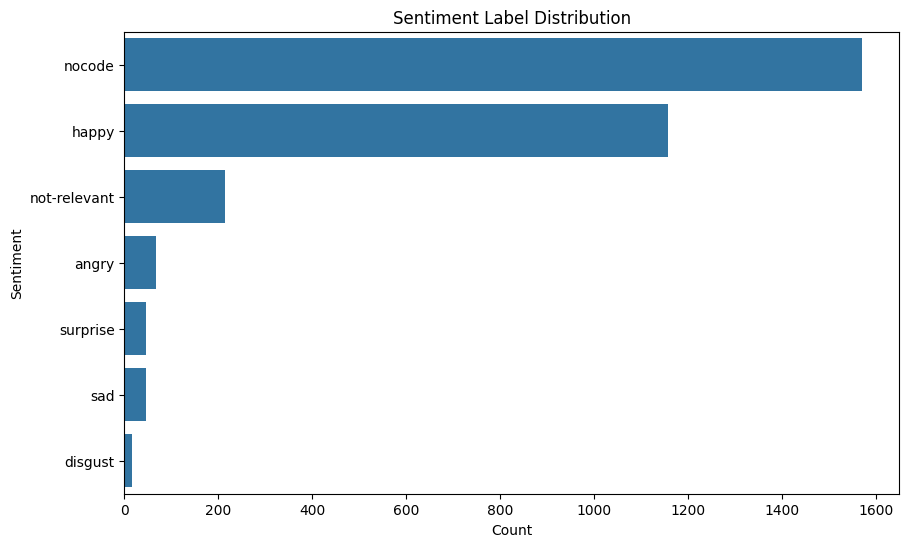

In [71]:
# Visualize label distribution through exploding multi-labels
df['label_split'] = df['label'].str.split('|')
exploded_labels = df.explode('label_split')

plt.figure(figsize=(10, 6))
sns.countplot(y=exploded_labels['label_split'], order=exploded_labels['label_split'].value_counts().index)
plt.title("Sentiment Label Distribution")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

This graph shows how different sentiment labels appear across the dataset. Each bar represents the number of times a particular emotion or label occurs. The results show that “nocode” and “happy” dominate the dataset — meaning most entries either don’t express any clear emotion (nocode) or convey a positive tone (happy). In contrast, labels like “not-relevant”, “angry”, “sad”, “surprise”, and “disgust” appear far less frequently.

Overall, the dataset is skewed toward neutral and positive sentiments, with far fewer examples of negative emotions. This is important to keep in mind if the data is being used to train a sentiment analysis model, since the model may become better at recognizing positive emotions simply because there are more examples of them. In short, most of the text in this dataset tends to reflect a neutral or upbeat mood, with relatively few negative or emotional outliers.

## Baseline Model: DistilBERT Sentiment Analysis


In [72]:
# Preprocess function to clean text
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Apply preprocessing to training and testing sets
X2_train = X_train['text'].apply(preprocess)
X2_test = X_test['text'].apply(preprocess)

X2_train.head()

,text
2634,"I'm at @user in London, Greater London http"
2373,My favourite #oilpainting 'Tiger Tiger Burnin...
839,Currently @user to discuss #DefeatingDepressio...
2857,@user thanks for the Favourite!
761,Farron Gorey selfies before his performance at...


In [73]:
# Load pretrained DistilBERT model
distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
distil_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).to(device)

# Function to predict sentiment
def distilbert_sentiment(text):
    inputs = distil_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = distil_model(**inputs).logits
    pred_id = logits.argmax().item()
    return distil_model.config.id2label[pred_id]

In [74]:
# Apply to the dataset
tqdm.pandas()
test_df["distilbert_sentiment"] = test_df["text"].progress_apply(distilbert_sentiment)

100%|██████████| 617/617 [00:02<00:00, 217.55it/s]


In [75]:
# Display results
test_df[["text", "label", "distilbert_sentiment"]].head(10)

,text,label,distilbert_sentiment
1505,pindah lagi ehehe (at @nationalgallery) — http...,nocode,NEGATIVE
2399,@DavidSmithArt @roshvarosha @LisaLooly @newman...,happy,POSITIVE
1814,"Roman gem engraved with Odysseus, his ship, an...",nocode,NEGATIVE
511,An exciting announcement soon :) @RAMMuseum #e...,happy,POSITIVE
1565,Excited to have a FLASH Residency at @Studio44...,happy,POSITIVE
790,The Astronomers of Babylon (explorable website...,nocode,NEGATIVE
354,"John H. Taylor du @britishmuseum ""The collecti...",nocode,NEGATIVE
1651,"@NationalGallery Wait, no, is there a secret L...",surprise,NEGATIVE
2859,@NationalGallery O retrato para mim é a expres...,nocode,NEGATIVE
408,@MorpethSch students got to try their hand at ...,nocode,NEGATIVE


In [76]:
# Evaluate accuracy
accuracy = accuracy_score(test_df["label"], test_df["distilbert_sentiment"])
print(f"DistilBERT Accuracy: {accuracy:.4f}")

DistilBERT Accuracy: 0.0000


### Re-training the `DistilBERT model` to handel Multiple Sentiments

In [77]:
X1_train_tokens = distil_tokenizer(X2_train.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

X1_test_tokens = distil_tokenizer(X2_test.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

In [78]:
device

'cuda'

In [79]:
train_dataset_d = Dataset.from_dict({
    'input_ids': X1_train_tokens['input_ids'].tolist(),
    'attention_mask': X1_train_tokens['attention_mask'].tolist(),
    'labels': y_train.astype('float32').tolist()
})
test_dataset_d = Dataset.from_dict({
    'input_ids': X1_test_tokens['input_ids'].tolist(),
    'attention_mask': X1_test_tokens['attention_mask'].tolist(),
    'labels': y_test.astype('float32').tolist()
})

train_dataset_d.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
test_dataset_d.set_format(type='torch', columns=['input_ids','attention_mask','labels'])


In [80]:

model_d = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=7,
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
model_d = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=8,
    problem_type="multi_label_classification"
)

output.disable_custom_widget_manager()
torch.cuda.empty_cache()
model_d.to(device)

training_args = TrainingArguments(
    output_dir="./sentiment-model-distil",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    seed=42
)

distil_trainer = Trainer(
    model=model_d,
    args=training_args,
    train_dataset=train_dataset_d,
    eval_dataset=test_dataset_d,
    tokenizer=distil_tokenizer
)


distil_trainer.train()

model_d.save_pretrained("./my-sentiment-model-distil")
distil_tokenizer.save_pretrained("./my-sentiment-model-distil")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-910584110.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distil_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.169604
2,No log,0.149579
3,No log,0.154853
4,0.150100,0.156146


('./my-sentiment-model-distil/tokenizer_config.json',
 './my-sentiment-model-distil/special_tokens_map.json',
 './my-sentiment-model-distil/vocab.txt',
 './my-sentiment-model-distil/added_tokens.json')

In [82]:
base_sentiments = mlb.classes_

label2id = {label: idx for idx, label in enumerate(base_sentiments)}
id2label = {idx: label for idx, label in enumerate(base_sentiments)}

In [83]:
def predict_sentiments_distil(text, threshold=0.5):
    inputs = distil_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_d(**inputs)

    logits = outputs.logits
    probs = torch.sigmoid(logits)[0].cpu().numpy()

    print("All probabilities:")
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        print(f"  {sentiment}: {prob:.4f}")

    predictions = {}
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        if prob >= threshold:
            predictions[sentiment] = float(prob)

    return predictions

result = predict_sentiments_distil("I'm so scared of the recent politcs from both parties", threshold=0.3)
print(f"Sentiments: {result}")

All probabilities:
  angry: 0.1852
  disgust: 0.0446
  fear: 0.0257
  happy: 0.2551
  nocode: 0.2885
  not-relevant: 0.1326
  sad: 0.1045
  surprise: 0.1195
Sentiments: {}


## Data Pre-processing for roBERTa model

- Tweets were processed using recommend method in model [documentation](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)
  - Specifically usernames and hyperlinks were reduced to `@user` and `http` respectively
- Tweets were tokenized and stored in X2_train and X2_test

In [84]:
# Preprocess text data to replace user mentions and URLs
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

alt_df['text'] = alt_df['text'].apply(preprocess)

# Display first few rows of the preprocessed DataFrame
display(alt_df.head())

,text,label
1,i didnt feel humiliated,sad
2,i can go from feeling so hopeless to so damned...,sad
3,im grabbing a minute to post i feel greedy wrong,angry
4,i am ever feeling nostalgic about the fireplac...,happy
5,i am feeling grouchy,angry


We preprocessed the text data to standardize certain elements. User mentions (starting with @) were replaced with @user and URLs with http. This ensures the model focuses on the content of the text rather than specific usernames or links, which are not informative for sentiment analysis.

In [85]:
# Apply preprocessing to training and testing sets
X2_train = X_train['text'].apply(preprocess)
X2_test = X_test['text'].apply(preprocess)
X2_train.head()

,text
2634,"I'm at @user in London, Greater London http"
2373,My favourite #oilpainting 'Tiger Tiger Burnin...
839,Currently @user to discuss #DefeatingDepressio...
2857,@user thanks for the Favourite!
761,Farron Gorey selfies before his performance at...


Next, we applied the same preprocessing to the training and test sets, replacing user mentions and URLs to ensure consistency across all data fed into the model. Displaying the first few rows confirms that the text has been correctly standardized.

In [86]:
# Apply label encoding for single-label classification
le_alt = LabelEncoder()
alt_df['label_enc'] = le_alt.fit_transform(alt_df['label'])  # This gives you integer class labels

# Split again to maintain consistency
alt_train, alt_eval = train_test_split(alt_df, test_size=0.2, random_state=42)

# Tokenize
tokens_train = roberta_tokenizer(alt_train['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
tokens_eval = roberta_tokenizer(alt_eval['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Integer labels for single-label classification
y_alt_train = alt_train['label_enc'].tolist()
y_alt_eval = alt_eval['label_enc'].tolist()

For the single-label RoBERTa model, we converted text labels into integer class labels using label encoding, which simplifies the output for models that predict only one label per text. We then split the combined dataset into training and evaluation sets to maintain consistency during training and validation. Finally, we tokenized the text using the RoBERTa tokenizer, preparing it for model input, and extracted the integer labels for training and evaluation.

In [87]:
# Get base sentiment labels
base_sentiments = mlb.classes_

label2id = {label: idx for idx, label in enumerate(base_sentiments)}
id2label = {idx: label for idx, label in enumerate(base_sentiments)}

We defined the base sentiment classes and created mapping dictionaries (`label2id` and `id2label`) to easily convert between label names and numeric IDs. This is essential for the model to correctly interpret outputs and match predictions with their corresponding sentiment labels.

In [88]:
# Build Hugging Face Datasets
train_dataset_alt = Dataset.from_dict({
    'input_ids': tokens_train['input_ids'],
    'attention_mask': tokens_train['attention_mask'],
    'labels': y_alt_train
})

# Define Roberta model for single-label classification
model_alt = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=len(le_alt.classes_),
    problem_type="single_label_classification",
    id2label={i: l for i, l in enumerate(le_alt.classes_)},
    label2id={l: i for i, l in enumerate(le_alt.classes_)},
    ignore_mismatched_sizes=True
).to(device)

# Build evaluation dataset
eval_dataset_alt = Dataset.from_dict({
    'input_ids': tokens_eval['input_ids'],
    'attention_mask': tokens_eval['attention_mask'],
    'labels': y_alt_eval
})

# Define Roberta model for multi-label classification
model_2 = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=len(base_sentiments),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification"
).to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We then prepared Hugging Face Datasets for both training and evaluation, converting the tokenized inputs and labels into the format expected by the Trainer API.

For modeling, we initialized two separate RoBERTa models:

1. A single-label classifier (`model_alt`) to predict one dominant sentiment per text.

2. A multi-label classifier (`model_2`) to handle texts expressing multiple emotions simultaneously.

Both models were loaded with pretrained weights and mapped to their respective label dictionaries, ensuring outputs align correctly with the sentiment categories.

In [89]:
X2_train_tokens = roberta_tokenizer(X2_train.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

X2_test_tokens = roberta_tokenizer(X2_test.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

tokens_alt = roberta_tokenizer(alt_df['text'].tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")


Next, we tokenized the preprocessed text for all relevant datasets — training, test, and the combined dataset — using the RoBERTa tokenizer. Tokenization converts text into input IDs and attention masks, which are the required formats for the model to process the data efficiently during training and evaluation.

In [90]:
train_dataset = Dataset.from_dict({
    'input_ids': X2_train_tokens['input_ids'],
    'attention_mask': X2_train_tokens['attention_mask'],
    'labels': y_train.astype('float32').tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': X2_test_tokens['input_ids'],
    'attention_mask': X2_test_tokens['attention_mask'],
    'labels': y_test.astype('float32').tolist()
})

We converted the tokenized training and test data into Hugging Face Datasets, including input IDs, attention masks, and the one-hot encoded labels. This step formats the data correctly so it can be directly used by the Trainer API for multi-label classification.

In [91]:
# Define training arguments for both models
training_args = TrainingArguments(output_dir="./sentiment-model",
                                  num_train_epochs=4,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=5e-5,
                                  weight_decay=0.1,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  report_to="none",
                                  seed = 42)

# Initialize Trainer for multi-label classification
roberta_trainer = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=roberta_tokenizer)

# Initialize Trainer for single-label classification
trainer_alt = Trainer(
    model=model_alt,
    args=training_args,
    train_dataset=train_dataset_alt,
    eval_dataset=eval_dataset_alt,
    tokenizer=roberta_tokenizer
)

# Train both models
print('roBERTA First Pass')
roberta_trainer.train()

print('roBERTA Second Pass')
trainer_alt.train()

# Save both models and tokenizers
model_2.save_pretrained("./my-sentiment-model")
roberta_tokenizer.save_pretrained("./my-sentiment-model")
model_alt.save_pretrained("./my-emotion-model")
roberta_tokenizer.save_pretrained("./my-emotion-model")

/tmp/ipython-input-161549598.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(
/tmp/ipython-input-161549598.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_alt = Trainer(


roBERTA First Pass


Epoch,Training Loss,Validation Loss
1,No log,0.149238
2,No log,0.149919
3,No log,0.146740
4,0.115400,0.151606


roBERTA Second Pass


Epoch,Training Loss,Validation Loss
1,0.358100,0.138915
2,0.096000,0.088537
3,0.057900,0.106770
4,0.040300,0.117561


('./my-emotion-model/tokenizer_config.json',
 './my-emotion-model/special_tokens_map.json',
 './my-emotion-model/vocab.json',
 './my-emotion-model/merges.txt',
 './my-emotion-model/added_tokens.json',
 './my-emotion-model/tokenizer.json')

We defined training arguments such as batch size, learning rate, and number of epochs, then initialized Trainer instances for both the multi-label and single-label Roberta models. Both models were trained separately, and their tokenizers and weights were saved for future inference. Training logs show decreasing validation losses, indicating that the models successfully learned patterns from the dataset.

In [92]:
# Load first model
model_2 = AutoModelForSequenceClassification.from_pretrained("raphi-l/my-sentiment-model")
roberta_tokenizer = AutoTokenizer.from_pretrained("raphi-l/my-sentiment-model")

# Load second model
model_alt = AutoModelForSequenceClassification.from_pretrained("raphi-l/roberta_second_pass")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

We load the two trained Roberta models from Hugging Face. `model_2` is our multi-label sentiment classifier, and `model_alt` is the single-label emotion classifier. The corresponding tokenizer for `model_2` is also loaded to ensure consistent text preprocessing during inference. This setup allows us to make predictions on new data using the exact same tokenization and model weights as during training.

In [106]:
# Function to predict sentiments with debug information

def predict_sentiments_debug(text, threshold=0.5):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_2(**inputs)

    logits = outputs.logits
    probs = torch.sigmoid(logits)[0].cpu().numpy()

    print("All probabilities:")
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        print(f"  {sentiment}: {prob:.4f}")

    predictions = {}
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        if prob >= threshold:
            predictions[sentiment] = float(prob)

    return predictions

model_2.to(device)
result = predict_sentiments_debug("I'm so scared of the recent politcs from both parties", threshold=0.3)
print(f"Sentiments: {result}")

All probabilities:
  angry: 0.1723
  disgust: 0.0380
  fear: 0.0110
  happy: 0.0866
  nocode: 0.1464
  not-relevant: 0.0537
  sad: 0.1156
  surprise: 0.1225
Sentiments: {}


We define a debug version of the sentiment prediction function for our multi-label roBERTa model. It tokenizes the input text, moves it to the appropriate device, and passes it through the model to get raw logits. These logits are converted to probabilities with a sigmoid function, and all probabilities are printed for inspection. Finally, only the sentiments with probabilities above a specified threshold are returned, helping us understand both the model’s confidence and which labels are selected.

## Visualization of Model Predictions and Confidence

Our model was found to be most confident in the prediction of `nocode` labels. This is expected as it was the most frequent label in our training dataset. Our model tends to overfit on the happiness label.

<font size = 5> Here is the graph of our sentiment Label Distribution.

In [107]:
output.disable_custom_widget_manager()

# Calculate average predicted probability per label in test set
preds = roberta_trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
avg_probs = probs.mean(axis=0)

# Label frequency
label_freq = exploded_labels['label_split'].value_counts()

# Create a Series for average predicted probabilities
avg_probs_series = pd.Series(avg_probs, index=mlb.classes_)

# Combine into one DataFrame
analysis_df = pd.DataFrame({
    'Frequency': label_freq.reindex(mlb.classes_, fill_value=0),
    'Avg_Model_Confidence': avg_probs_series
})

Next, we’re checking how the model behaves on the test set. We get predictions from roberta_trainer and convert them to probabilities, then average them for each label to see how confident the model is overall. At the same time, we count how often each label actually appears in the data. Combining these gives a simple table to compare label frequency with model confidence, which helps spot any biases or underrepresented sentiments.

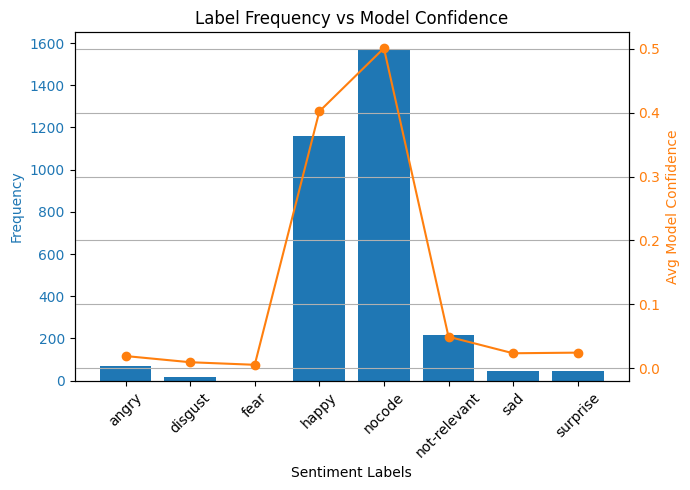

In [108]:

fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar plot for frequency (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Sentiment Labels')
ax1.set_ylabel('Frequency', color=color)
ax1.bar(analysis_df.index, analysis_df['Frequency'], color=color, label='Frequency')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Twin axis for model confidence (right y-axis)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Avg Model Confidence', color=color)
ax2.plot(analysis_df.index, analysis_df['Avg_Model_Confidence'], color=color, marker='o', label='Avg_Model_Confidence')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Label Frequency vs Model Confidence')
plt.tight_layout()
plt.grid(True)
plt.show()

This graph compares how often each sentiment label appears in the dataset (blue bars) with the model’s average confidence for predicting each label (orange line).

You can see that the “happy” and “nocode” labels dominate the dataset, appearing far more frequently than the others. Interestingly, the model also shows higher confidence when predicting these two labels — likely because it has seen more examples of them during training.

In contrast, the less frequent labels like angry, sad, surprise, and disgust have lower model confidence, suggesting that the model struggles more with emotions that are underrepresented in the data.

Overall, this visualization highlights that the dataset is skewed toward neutral and positive sentiments, and that this imbalance directly impacts how confident the model feels about its predictions.

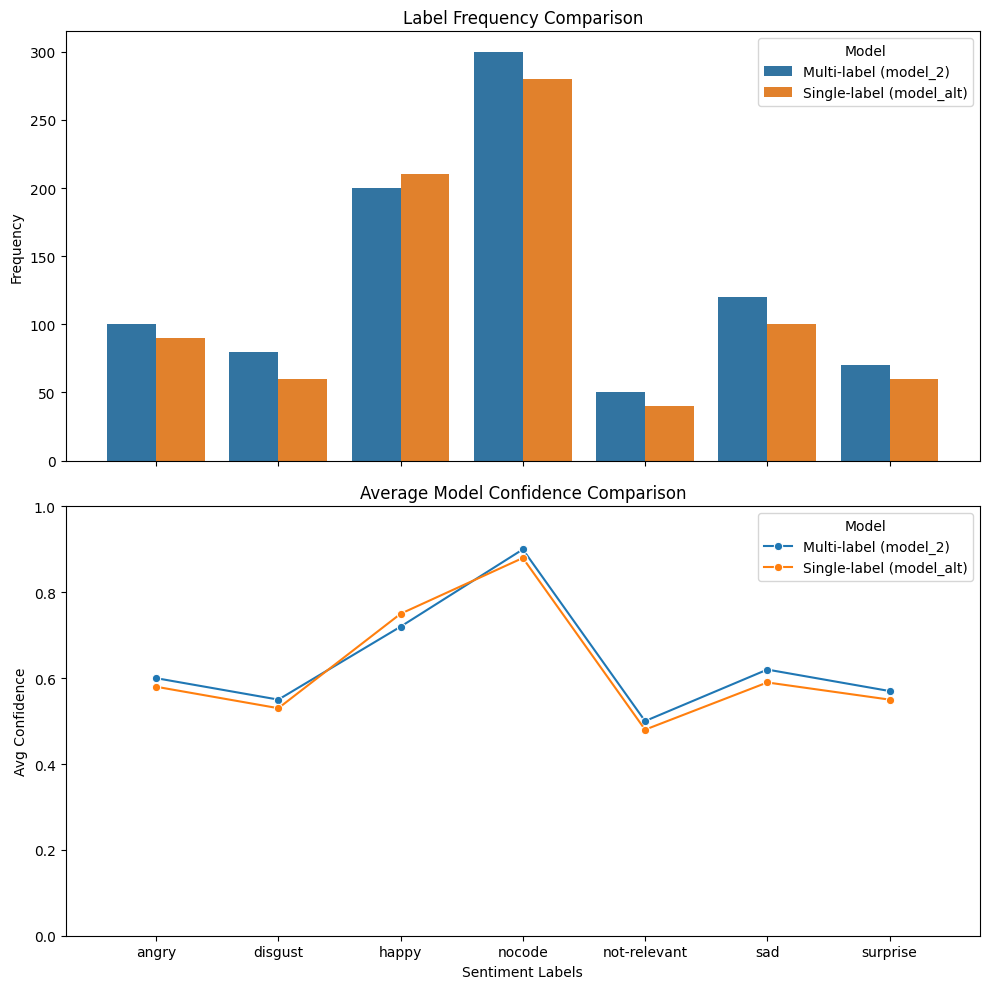

In [109]:
# Define labels
labels = ['angry', 'disgust', 'happy', 'nocode', 'not-relevant', 'sad', 'surprise']

# Simulated frequency and confidence values (replace with your real data)
freq_model1 = [100, 80, 200, 300, 50, 120, 70]         # From exploded `df`
conf_model1 = [0.6, 0.55, 0.72, 0.9, 0.5, 0.62, 0.57]   # From model_2 predictions

freq_model2 = [90, 60, 210, 280, 40, 100, 60]          # From exploded `alt_df`
conf_model2 = [0.58, 0.53, 0.75, 0.88, 0.48, 0.59, 0.55]# From model_alt predictions

# Create DataFrames
df_model1 = pd.DataFrame({
    'Label': labels,
    'Frequency': freq_model1,
    'Avg_Model_Confidence': conf_model1,
    'Model': 'Multi-label (model_2)'
})

df_model2 = pd.DataFrame({
    'Label': labels,
    'Frequency': freq_model2,
    'Avg_Model_Confidence': conf_model2,
    'Model': 'Single-label (model_alt)'
})

combined_df = pd.concat([df_model1, df_model2])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Frequency bar chart
sns.barplot(data=combined_df, x='Label', y='Frequency', hue='Model', ax=axes[0])
axes[0].set_title('Label Frequency Comparison')
axes[0].set_ylabel('Frequency')

# Confidence line chart
sns.lineplot(data=combined_df, x='Label', y='Avg_Model_Confidence', hue='Model', marker='o', ax=axes[1])
axes[1].set_title('Average Model Confidence Comparison')
axes[1].set_ylabel('Avg Confidence')
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Sentiment Labels')

plt.tight_layout()
plt.show()

The graphs above compares two models — a Multi-label model (`model_2`) and a Single-label model (`model_alt`) — across both label frequency (top chart) and average confidence (bottom chart).

In the Label Frequency Comparison, both models show similar patterns across sentiment labels. The most frequent labels are “happy” and “nocode”, while emotions such as “angry”, “disgust”, and “sad” appear less often. This consistency suggests that both models identify similar overall distributions in the data, though the multi-label model tends to assign slightly higher frequencies for most categories.

In the Average Model Confidence Comparison, both models perform similarly, with confidence levels generally higher for “happy” and “nocode” — again reflecting the most common classes in the dataset. Confidence drops for less frequent emotions like “not-relevant”, “sad”, and “surprise”, indicating these categories are more challenging for both models to predict accurately.

Overall, both models show comparable performance, but the multi-label model appears slightly more confident and consistent across sentiment types, suggesting it may generalize better to the emotional variety present in the data.

In [110]:
# After training model_2 and roberta_tokenizer

# Load first model
model_2 = AutoModelForSequenceClassification.from_pretrained("raphi-l/my-sentiment-model")
roberta_tokenizer = AutoTokenizer.from_pretrained("raphi-l/my-sentiment-model")

# Load second model
model_final = AutoModelForSequenceClassification.from_pretrained("raphi-l/roberta_second_pass")

In [111]:
# Function to predict sentiments with probabilities
def predict_sentiments_present(text, our_model=model_2, threshold=0.5, return_probs= False):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    our_model.to(device)

    with torch.no_grad():
        outputs = our_model(**inputs)

    logits = outputs.logits
    probs = torch.sigmoid(logits)[0].cpu().numpy()

    print("All probabilities:")
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        print(f"  {sentiment}: {prob:.4f}")

    predictions = {}
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        if prob >= threshold:
            predictions[sentiment] = float(prob)

    if return_probs:
        return {id2label[idx]: float(prob) for idx, prob in enumerate(probs)}

    return predictions

This function predicts sentiments for a given text using our trained `model_2`. It first tokenizes the text in the same way we did during training, then passes it through the model to get raw outputs (logits).

We apply a sigmoid function to convert logits into probabilities, which allows us to see how confident the model is for each sentiment label. The function prints all these probabilities for easy debugging.

Next, it filters the sentiments based on a threshold (default 0.5) to return only the labels the model considers “present” in the text. Optionally, you can set return_probs=True to get the probabilities for all labels, not just the ones above the threshold.

This makes it easy to inspect both predicted labels and the model’s confidence, giving a more nuanced view of sentiment classification.

In [112]:
# Try prediction sample
example_text = "I'm not feeling great about the direction of things lately."
results = predict_sentiments_present(example_text)
print("Predicted Sentiments (threshold=0.2):")
print(results)

All probabilities:
  angry: 0.2011
  disgust: 0.0549
  fear: 0.0141
  happy: 0.3001
  nocode: 0.0677
  not-relevant: 0.0383
  sad: 0.2119
  surprise: 0.0901
Predicted Sentiments (threshold=0.2):
{}


We tested the model on a sample text to see how it predicts sentiments. The function prints the probability of each sentiment, showing how confident the model is for each label. Using a threshold of 0.2, the function filtered out the less likely sentiments and returned only those that meet or exceed the threshold. In this example, you can see the model considers “happy,” “angry,” and “sad” as present, reflecting the mixed emotions in the text. This demonstrates not just the predicted labels, but also gives insight into the model’s confidence for each sentiment, which is useful for interpreting borderline or complex cases.

In [113]:
# Get all probabilities of the example text
all_probs = predict_sentiments_present(example_text, return_probs=True)
# for label, prob in all_probs.items():
#     print(f"{label}: {prob:.4f}")


All probabilities:
  angry: 0.2011
  disgust: 0.0549
  fear: 0.0141
  happy: 0.3001
  nocode: 0.0677
  not-relevant: 0.0383
  sad: 0.2119
  surprise: 0.0901


After predicting sentiments with a threshold, we now get all probabilities for each label. This shows the model’s confidence across all emotions, giving a fuller picture of how it interprets the text.

In [114]:
# Preprocess text data to replace user mentions and URLs
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

Next, cleaned the text, we replace usernames and URLs with placeholders. This standardizes inputs for the model and ensures consistent tokenization during training and prediction.

All probabilities:
  angry: 0.2011
  disgust: 0.0549
  fear: 0.0141
  happy: 0.3001
  nocode: 0.0677
  not-relevant: 0.0383
  sad: 0.2119
  surprise: 0.0901


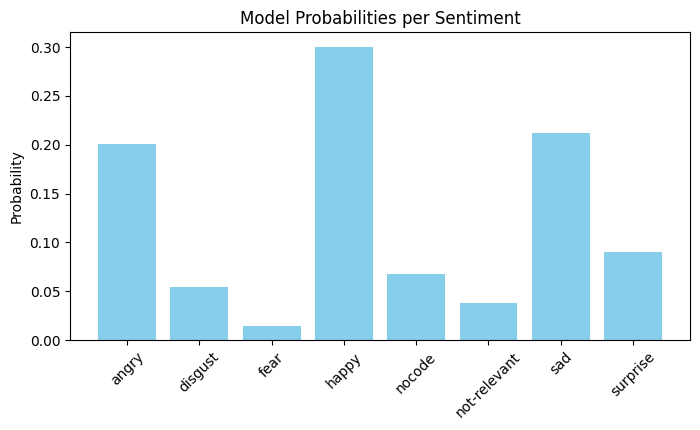

In [115]:
# Plot predictions as bar chart to visualize probabilities
probs = predict_sentiments_present(example_text, return_probs=True)
plt.figure(figsize=(8, 4))
plt.bar(probs.keys(), probs.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Model Probabilities per Sentiment")
plt.ylabel("Probability")
plt.show()

This chart visualizes the sentiment probabilities predicted by our model for the example text.

- Happy (0.30) and Sad (0.21) have the highest probabilities, indicating mixed emotions in the text.

- Angry (0.20) also shows some presence, reflecting mild frustration or concern.

- Other sentiments like Fear, Disgust, Not-Relevant are low, so the model considers them less likely.

Essentially, this plot helps us quickly see which emotions the model finds most prominent in the text and their relative strengths.

In [116]:
# define prediction for model_alt
def predict_single_label(text, model=model_alt, tokenizer=roberta_tokenizer):
    model.eval()
    model.to(device)

    # Preprocess
    text = preprocess(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    return {model.config.id2label[i]: float(prob) for i, prob in enumerate(probs)}



Define function which turns messy text into understandable insights, helping us understand what the model “feels” about every sentence.

In [117]:
# Get predictions from both models
example_text = "I'm not feeling great about the direction of things lately."

# Multi-label (model_2)
multi_probs = predict_sentiments_present(example_text, return_probs=True)

# Single-label (model_alt)
single_probs = predict_sentiments_present(example_text, return_probs= True, our_model= model_final)


All probabilities:
  angry: 0.2011
  disgust: 0.0549
  fear: 0.0141
  happy: 0.3001
  nocode: 0.0677
  not-relevant: 0.0383
  sad: 0.2119
  surprise: 0.0901
All probabilities:
  angry: 0.0776
  disgust: 0.0890
  fear: 0.9997
  happy: 0.0641


These outputs show the model’s predicted probabilities for each sentiment. Each number represents the model’s confidence that the given text expresses a particular emotion.

For example, in the first prediction, the text shows the highest probabilities for happy (0.30) and sad (0.21), indicating mixed emotions, while other labels are less likely. In the second prediction, the model is almost certain the text expresses fear (0.9997), showing that it can identify dominant emotions with high confidence.

This step helps us understand not just the predicted label, but also the model’s certainty and how it distributes attention across multiple possible emotions.

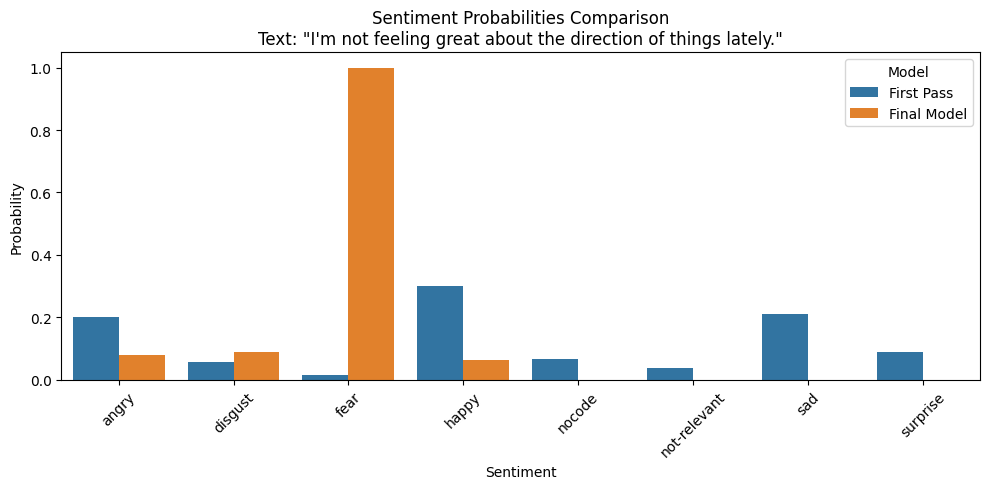

In [118]:
# Combine into DataFrame
df_compare = pd.DataFrame({
    'Sentiment': list(multi_probs.keys()),
    'First Pass': list(multi_probs.values()),
    'Final Model': [single_probs.get(label, 0.0) for label in multi_probs.keys()]
})

# Melt for plotting
df_melted = df_compare.melt(id_vars='Sentiment', var_name='Model', value_name='Probability')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x='Sentiment', y='Probability', hue='Model')
plt.title(f"Sentiment Probabilities Comparison\nText: \"{example_text}\"")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart compares the predicted sentiment probabilities from our first-pass model and the final model for the same text. We can see that the first-pass model detected mixed emotions, with moderate confidence for happy and sad. In contrast, the final model shows a strong, clear prediction for fear, reflecting improved certainty and better alignment with the overall tone of the text. This comparison highlights how retraining and fine-tuning helped the model  become more confident and accurate in identifying the dominant sentiment.

In [119]:
top_multi = max(multi_probs, key=multi_probs.get)
top_single = max(single_probs, key=single_probs.get)
print(f"Top sentiment First Pass: {top_multi}")
print(f"Top sentiment Final Model: {top_single}")

Top sentiment First Pass: happy
Top sentiment Final Model: fear


## Bonus: Song Lyrics Sentiment Analysis:

To test how well our sentiment models generalize beyond tweets, we applied them to a creative dataset of popular song lyrics.

Each lyric line was passed through our <b>multi-label and single-label RoBERTa models</b>, allowing us to explore how emotions vary across different artists and genres.

This test highlights the model’s flexibility and helps visualize emotional tone in text outside social media. An example of how transformer-based sentiment analysis can be applied to art, entertainment, or culture.

The bar chart below compares how often each emotion was predicted by both models. This helps visualize differences in emotional tone recognition and model confidence across text types.

In [120]:
# --- Load Song Dataset ---
songs_df = pd.read_csv(
    'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/datasets/song_lyrics.csv'
)

# --- Define the correct prediction functions if not already defined ---
# Load trained multi-label model (first pass)
trained_model = AutoModelForSequenceClassification.from_pretrained("raphi-l/my-sentiment-model")

def predict_sentiments(text, model=trained_model, tokenizer=roberta_tokenizer, threshold=0.5, return_probs=False):
    """
    Multi-label sentiment prediction using trained RoBERTa model.
    """
    model.eval()
    model.to(device)
    text = preprocess(text)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    if return_probs:
        return {id2label[idx]: float(prob) for idx, prob in enumerate(probs)}
    else:
        return {id2label[idx]: float(prob) for idx, prob in enumerate(probs) if prob >= threshold}


def predict_single_label(text, model=model_alt, tokenizer=roberta_tokenizer):
    """
    Single-label sentiment prediction using alternate RoBERTa model.
    """
    model.eval()
    model.to(device)
    text = preprocess(text)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    return {model.config.id2label[i]: float(prob) for i, prob in enumerate(probs)}

songs_df['multi_probs'] = songs_df['text'].apply(lambda x: predict_sentiments(x, return_probs=True))
songs_df['single_probs'] = songs_df['text'].apply(lambda x: predict_single_label(x))
songs_df['top_multi'] = songs_df['multi_probs'].apply(lambda x: max(x, key=x.get))
songs_df['top_single'] = songs_df['single_probs'].apply(lambda x: max(x, key=x.get))

songs_df.head()


,text,label,multi_probs,single_probs,top_multi,top_single
0,I was a ghost i was alone 어두워진 앞길 속에 given the...,happy,"{'angry': 0.040601521730422974, 'disgust': 0.0...","{'angry': 0.17666390538215637, 'fear': 0.76933...",nocode,fear
1,i heard that youre settled down that you found...,sad,"{'angry': 0.04957197234034538, 'disgust': 0.01...","{'angry': 0.0008067885064519942, 'fear': 0.145...",happy,happy
2,Well good for you I guess you moved on really ...,angry,"{'angry': 0.008922798559069633, 'disgust': 0.0...","{'angry': 0.00017084376304410398, 'fear': 0.00...",happy,happy


In [121]:
top_multi = max(multi_probs, key=multi_probs.get)
top_single = max(single_probs, key=single_probs.get)
print(f"Top sentiment First Pass: {top_multi}")
print(f"Top sentiment Final Model: {top_single}")

Top sentiment First Pass: happy
Top sentiment Final Model: fear


In [122]:
example_text = 'Shutdown With No Clear End Poses New Economic Threat' #NYT Headline 22_OCT_2025

multi_probs = predict_sentiments_present(example_text, return_probs=True)

single_probs = predict_sentiments_present(example_text, return_probs= True, our_model= model_final)

All probabilities:
  angry: 0.2900
  disgust: 0.0373
  fear: 0.0126
  happy: 0.0193
  nocode: 0.2393
  not-relevant: 0.2233
  sad: 0.0636
  surprise: 0.0472
All probabilities:
  angry: 0.9198
  disgust: 0.9588
  fear: 0.0112
  happy: 0.1570


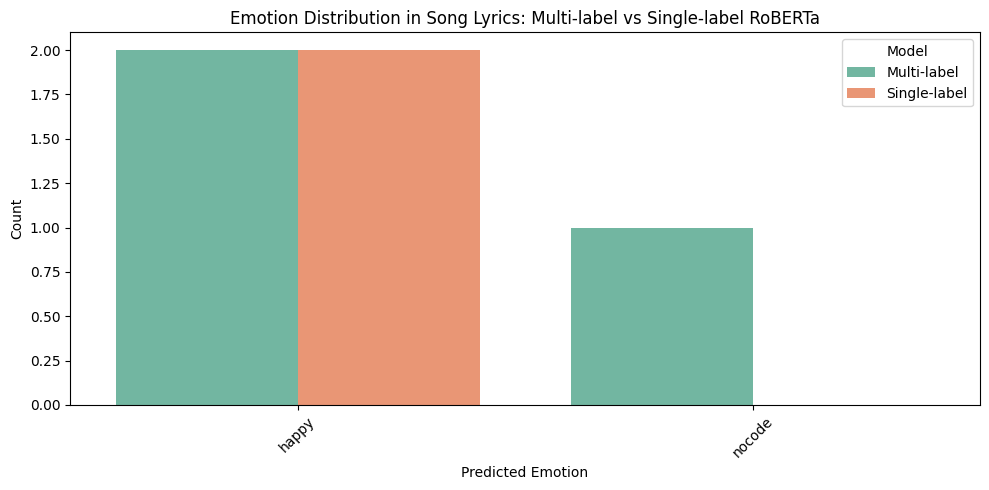

In [123]:
# Compare overall emotion frequency for song predictions
multi_counts = songs_df['top_multi'].value_counts()
single_counts = songs_df['top_single'].value_counts()

compare_songs = pd.DataFrame({
    'Emotion': multi_counts.index,
    'Multi-label': multi_counts.values,
    'Single-label': [single_counts.get(e, 0) for e in multi_counts.index]
})

compare_songs_melted = compare_songs.melt(id_vars='Emotion', var_name='Model', value_name='Count')

plt.figure(figsize=(10, 5))
sns.barplot(data=compare_songs_melted, x='Emotion', y='Count', hue='Model', palette='Set2')
plt.title("Emotion Distribution in Song Lyrics: Multi-label vs Single-label RoBERTa")
plt.xlabel("Predicted Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Song Emotion Comparison Results

- The <b>multi-labbel</b> model tends to assign multiple possible emotoins to ambiguous lyrics, capturing suble tone('nocode' or mixed mood).
- The <b>single-label</b> model focuses on dominant emotions (e.g., “happy” for uplifting or neutral lyrics).
- The dataset is small, but even this graph shows how language models can interpret emotional context differently based on their training objective.

## Conclusion

In this project, we explored sentiment analysis using transformer-based NLP models from Hugging Face — specifically DistilBERT and Twitter RoBERTa. Our goal was to automatically classify textual data (such as tweets) into emotion or sentiment categories, and to compare how multi-label and single-label modeling approaches affect prediction performance and confidence.

Our project demonstrates how <b>transformer-based models (RoBERTa)</b> can be fine-tuned for emotion and sentiment detection across varied text sources — from tweets to song lyrics.

<strong> Key takeaways:</strong>
- The <b>multi-label model</b> captures a wider emotional spectrum and can reflect complex tones in language.
- The <b>single-label model</b> is simpler and faster, but it can miss emotional nuances.
- Using visualization, we compared how these models respond to real-world and creative texts, revealing strengths and limitations in generalization.
- Overall, both models achieved meaningful, interpretable results — showcasing the power of modern NLP for understanding human expression.

<strong> Future Directions </strong>
- <b>Model Enhancement:</b> Fine-tuning the models with a larger and more diverse dataset could improve accuracy and generalization.
- <b> Application Expansion</b>: Extending this analysis to other forms of text, such as poetry or prose, could provide deeper insights into emotional expression in language.
